In [7]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import nn
from sklearn.decomposition import PCA

# Load data and create datasets

In [8]:
datastore = h5py.File('trials6.h5', 'r')
batch_size = 100
n_comp = 40

raw_I = np.array(datastore["I"])
raw_T = np.array(datastore["T"])
raw_c = np.array(datastore["c"])
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

pcaI = PCA(n_components=n_comp)
pcaI.fit(raw_I)
pcaT = PCA(n_components=n_comp)
pcaT.fit(raw_T)
pcac = PCA(n_components=n_comp)
pcac.fit(raw_c)

raw_in = np.hstack((pcaI.transform(raw_I), pcaT.transform(raw_T)))
data_in = torch.tensor(raw_in).to(device)
data_c = torch.tensor(pcac.transform(raw_c)).to(device)

dataset = TensorDataset(data_in, data_c)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using mps device


# Define the model

In [9]:
class VarTransform(nn.Module):
    def __init__(self):
        super(VarTransform, self).__init__()

    def forward(self, x):
        # exp of the 4th input value; pass others unchanged
        x[:, 3] = torch.exp(x[:, 3])
        return x

class net(nn.Module):
    def __init__(self, n_components, width):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2*n_components, 80),
            nn.ReLU(),
            nn.Linear(80, width),
            nn.ReLU(),
            nn.Linear(width, 80),
            nn.ReLU(),
            nn.Linear(80, n_components),
        )

    def forward(self, x):
        y = self.layers(x)
        return y
    
class net_thin(nn.Module):
    def __init__(self, n_components, width):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2*n_components, width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.ReLU(),
            nn.Linear(width, n_components),
        )

    def forward(self, x):
        y = self.layers(x)
        return y

In [10]:
model = net_thin(n_comp,200).to(device)
print(model)

net_thin(
  (layers): Sequential(
    (0): Linear(in_features=80, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=40, bias=True)
  )
)


# Training

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Test Error: Avg loss = {test_loss:>8f} \n")

In [12]:
learning_rate = 2e-3
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 10.890828  [  100/32000]
loss: 1.985888  [10100/32000]
loss: 1.008875  [20100/32000]
loss: 0.590776  [30100/32000]
Test Error: Avg loss = 0.544461 

Epoch 2
-------------------------------
loss: 0.639848  [  100/32000]
loss: 0.404964  [10100/32000]
loss: 0.417970  [20100/32000]
loss: 0.310525  [30100/32000]
Test Error: Avg loss = 0.329096 

Epoch 3
-------------------------------
loss: 0.311477  [  100/32000]
loss: 0.162933  [10100/32000]
loss: 0.103522  [20100/32000]
loss: 0.351527  [30100/32000]
Test Error: Avg loss = 0.217786 

Epoch 4
-------------------------------
loss: 0.307361  [  100/32000]
loss: 0.289952  [10100/32000]
loss: 0.275025  [20100/32000]
loss: 0.113647  [30100/32000]
Test Error: Avg loss = 0.185691 

Epoch 5
-------------------------------
loss: 0.200667  [  100/32000]
loss: 0.098993  [10100/32000]
loss: 0.234795  [20100/32000]
loss: 0.101650  [30100/32000]
Test Error: Avg loss = 0.130341 

Epoch 6
---------------------

# Inspecting results

In [ ]:
model(data_in[10:13])

tensor([[ 0.0203,  0.0930,  0.1198, -0.0920,  0.1348,  0.1916, -0.0422, -0.1148,
          0.0854, -0.0580,  0.0338, -0.0610,  0.1750, -0.1082, -0.0762,  0.0272,
          0.0058, -0.0098,  0.0906,  0.0977, -0.0014, -0.0813,  0.0179,  0.1338,
          0.0379, -0.0384, -0.0226, -0.0607,  0.0393, -0.0296, -0.1277,  0.0770,
          0.0154, -0.0095, -0.1228, -0.0559, -0.0951, -0.0367,  0.1903, -0.0045],
        [ 0.0385,  0.0828,  0.0824,  0.0171,  0.0162,  0.0766, -0.0027, -0.0619,
          0.0946, -0.0431,  0.0206, -0.0067,  0.1002, -0.0552, -0.0694,  0.0156,
         -0.0460,  0.0307,  0.0568,  0.0396,  0.0039, -0.0461, -0.0219,  0.0782,
         -0.0229, -0.0276,  0.0114,  0.0342,  0.0069, -0.0209, -0.1098,  0.0298,
          0.0299,  0.0158, -0.0649, -0.0242, -0.0906, -0.0006,  0.0800, -0.0312],
        [ 0.0245,  0.1094,  0.0865,  0.0737, -0.0670,  0.0824,  0.0184, -0.0010,
          0.1025, -0.0543, -0.0040, -0.0331,  0.0978, -0.0072, -0.0283, -0.0018,
         -0.0426,  0.0762,

In [ ]:
data_c[10:13]

tensor([[-2.3195e+01,  2.0849e+00, -3.1785e-01,  5.2177e-02,  1.0395e-01,
         -7.3159e-02,  9.5243e-02, -7.3650e-02,  7.3238e-02, -5.8252e-02,
          5.2548e-02,  4.2110e-02, -3.7984e-02, -2.8706e-02,  2.5543e-02,
         -1.6209e-02,  1.2498e-02, -1.1070e-02, -4.2273e-03, -8.4655e-03,
          6.7207e-03, -8.5188e-03, -7.5793e-03,  4.5487e-03, -3.2559e-04,
          4.4747e-03, -4.3945e-03,  3.4527e-03,  7.3297e-04,  4.0403e-04,
          5.8584e-04,  6.2463e-04,  1.3813e-04,  7.1094e-04,  2.6375e-04,
         -1.4102e-03, -1.1289e-05, -9.3192e-04,  1.2624e-03,  1.6067e-04],
        [-1.4308e+01, -2.4845e+00,  2.3054e+00, -1.6995e+00,  1.3485e+00,
         -9.8763e-01,  7.2819e-01, -5.1755e-01,  3.7026e-01, -2.7222e-01,
          1.9547e-01,  1.4480e-01, -1.0394e-01, -7.0859e-02,  4.6763e-02,
         -2.6068e-02,  9.0804e-03, -6.9275e-03,  8.5999e-03, -1.3954e-02,
         -5.4482e-03, -1.4773e-02, -8.7819e-03,  3.7682e-03, -1.5234e-03,
          1.6469e-03,  6.3633e-04, -1

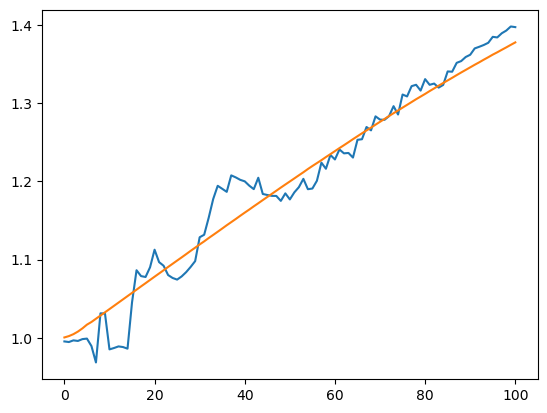

In [14]:
example = 70
with torch.no_grad():
    x, y = test_dataset[example]
    plt.plot(pcac.inverse_transform(model(x).cpu()))
    plt.plot(pcac.inverse_transform(y.cpu()))
plt.show()

# RMS error in time series

In [ ]:
with torch.no_grad():
    test_osmo_pred = np.zeros((0, 101))
    test_osmo_actual = np.zeros((0, 101))
    for (x, y) in test_dataloader:
        test_osmo_pred = np.vstack((test_osmo_pred, pcac.inverse_transform(model(x).cpu())))
        test_osmo_actual = np.vstack((test_osmo_actual, pcac.inverse_transform(y.cpu())))
    train_osmo_pred = np.zeros((0, 101))
    train_osmo_actual = np.zeros((0, 101))
    for (x, y) in train_dataloader:
        train_osmo_pred = np.vstack((train_osmo_pred, pcac.inverse_transform(model(x).cpu())))
        train_osmo_actual = np.vstack((train_osmo_actual, pcac.inverse_transform(y.cpu())))

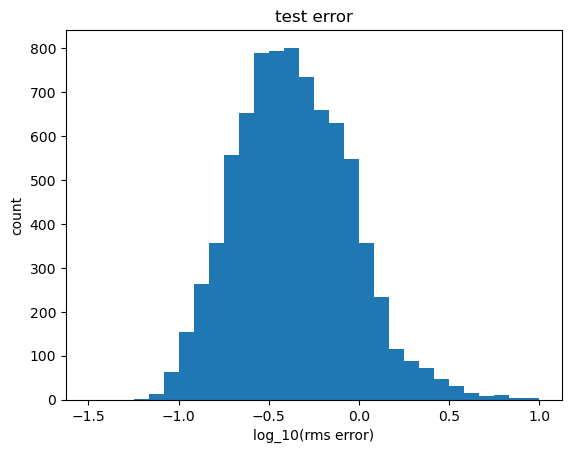

In [ ]:
rmserror = np.apply_along_axis(np.linalg.norm, 1, test_osmo_pred - test_osmo_actual)
plt.hist(np.log10(rmserror), bins=np.linspace(-1.5,1,31))
plt.xlabel('log_10(rms error)')
plt.ylabel('count')
plt.title('test error')
plt.show()

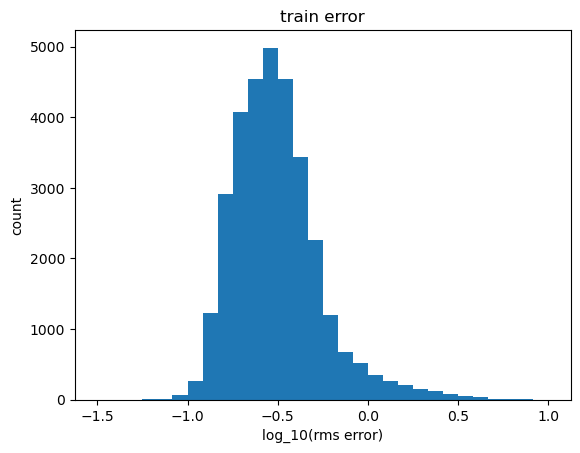

In [ ]:
rmserror = np.apply_along_axis(np.linalg.norm, 1, train_osmo_pred - train_osmo_actual)
plt.hist(np.log10(rmserror), bins=np.linspace(-1.5,1,31))
plt.xlabel('log_10(rms error)')
plt.ylabel('count')
plt.title('train error')
plt.show()

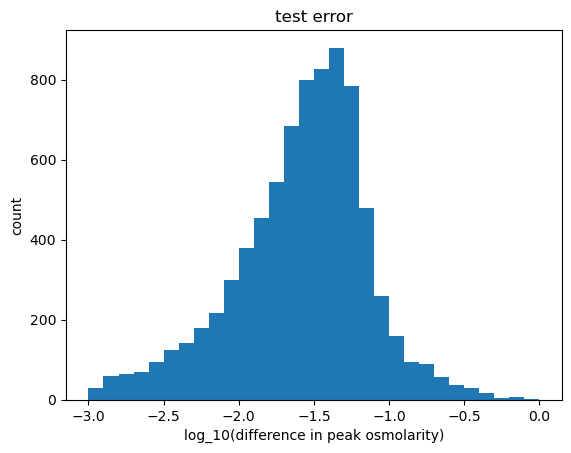

In [ ]:
peakerror = np.max(test_osmo_pred, axis=1) - np.max(test_osmo_actual, axis=1)
plt.hist(np.log10(np.abs(peakerror)), bins=np.linspace(-3,0,31))
plt.xlabel('log_10(difference in peak osmolarity)')
plt.ylabel('count')
plt.title('test error')
plt.show()

In [ ]:
#torch.save(model.state_dict(), 'model_osm_pca_size_40x200')